# Stenotrophomonas

Can we see what is driving the nine samples that have Steno?

Our Stenotrophomonas metadata columns are: 'CS_Stenophotomonas maltophilia', 'P12M_3_Stenotrophomonas maltophilia', 'N12M_Stenotrophomonas maltophilia'

In [1]:
import os
import sys
from socket import gethostname

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib

sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', taxa="family")

Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems


In [2]:
import shap

# Where is Stenotrophomonas

Note: in our taxonomy, Stenotrophomonas is listed as:

`k__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Xanthomonadales;f__Xanthomonadaceae;g__Stenotrophomonas`

but this is different from current NCBI taxonomy where it is a [Lysobacteriaceae](https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=40323)

Temporarily reseting this value. They have a lot of reads, and had it in the previous 12 months and the next 12 months, so somewhat surprised they don't have it on that date.

In [3]:
metadata.loc['698564_20171001_S', 'CS_Stenophotomonas maltophilia']

0

In [4]:
metadata.loc['698564_20171001_S', 'CS_Stenophotomonas maltophilia'] = 1

In [5]:
metadata.loc['698564_20171001_S', 'CS_Stenophotomonas maltophilia']

1

## Read the autoencoder

In [6]:
encoder_models = 'cluster_gbrfs'
if not os.path.exists(os.path.join(encoder_models, 'clusters.json')):
    print("Please run the autoencoder code before trying to load the models.", file=sys.stderr)
    exit(1)

if not os.path.exists(os.path.join(encoder_models, 'pc_df.tsv')):
    print("Please create and save the PCA before trying to load the models.", file=sys.stderr)
    exit(1)

with open(os.path.join(encoder_models, 'clusters.json'), 'r') as file:
    data = json.load(file)
tmpjsondf = pd.DataFrame(list(data.items()), columns=['COPF', 'Feature'])
cluster_assignments = tmpjsondf.explode('Feature').reset_index(drop=True)
cluster_assignments['COPF'] = cluster_assignments['COPF'].astype(int)

pc_df = pd.read_csv(os.path.join(encoder_models, 'pc_df.tsv'), sep="\t", index_col=0)

In [7]:
cluster_assignments[cluster_assignments['Feature'].str.lower().str.contains('xanthomon')]

,COPF,Feature
902,120,Xanthomonadaceae


## Run the GBRF

The data for the classifier is {'no': 117, 'yes': 10} variables
We used 52 estimators for the random forest classifier
Mean squared error for CS_Stenophotomonas maltophilia using classifier is 0.07692307692307693


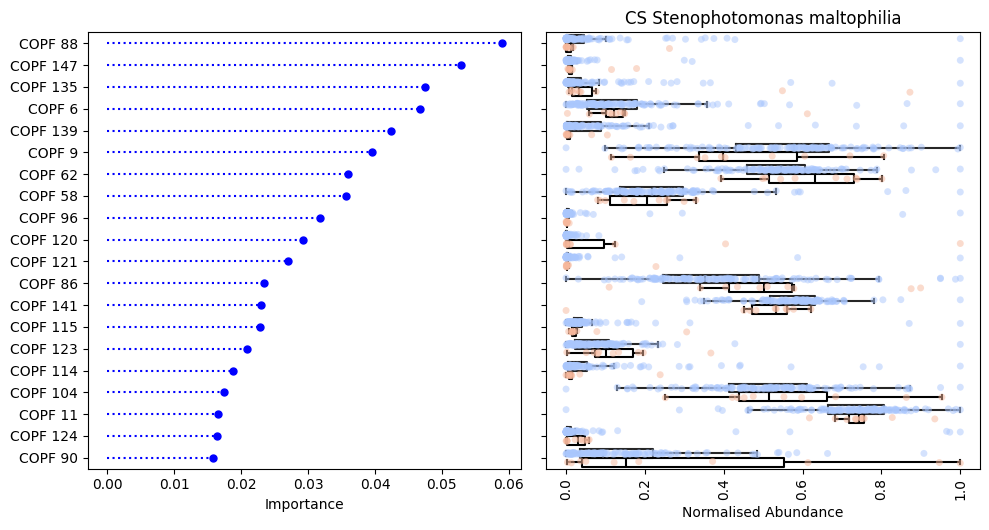

In [8]:
intcol = 'CS_Stenophotomonas maltophilia'

intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

if categorical_data:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y, n_estimators=1000, n_iter_no_change=20)
  met = 'classifier'
else:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
  met = 'regressor'

print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
print(f"Mean squared error for {intcol} using {met} is {mse}", file=sys.stderr)
cf_analysis_lib.plot_one_top_feature(merged_df, feature_importances_sorted, intcol, intcol_title, 
                                     custom_labels, plot_legend=False)

In [9]:
cluster_assignments[cluster_assignments['COPF']==88]

,COPF,Feature
565,88,Marinifilaceae
566,88,Catalimonadaceae
567,88,Flexibacteraceae
568,88,Fulvivirgaceae
569,88,Antibiotic anticapsin - bacilysin
570,88,Caedimonadaceae
571,88,Chloroherpetonaceae
572,88,Immundisolibacteraceae
573,88,Porphyromonadaceae


In [10]:
fis = feature_importances_sorted.reset_index().rename(columns={'index': 'COPF'})
print(fis.sort_values(by='importance', ascending=False).head(10))
print("...")
print(fis[fis['COPF']=='COPF 120'])

       COPF  importance
0   COPF 88    0.058921
1  COPF 147    0.052876
2  COPF 135    0.047450
3    COPF 6    0.046756
4  COPF 139    0.042386
5    COPF 9    0.039539
6   COPF 62    0.036009
7   COPF 58    0.035707
8   COPF 96    0.031861
9  COPF 120    0.029210
...
       COPF  importance
9  COPF 120     0.02921


## Box Plots

In [11]:
steno = metadata[['CS_Stenophotomonas maltophilia', 'P12M_3_Stenotrophomonas maltophilia', 'N12M_Stenotrophomonas maltophilia']].dropna(axis=0).copy()
merged = df[['Xanthomonadaceae']].join(steno, how='inner')
merged['log_Xanthomonadaceae'] = np.log10(df['Xanthomonadaceae']+1)
merged[merged['CS_Stenophotomonas maltophilia']==1].sort_values(by='Xanthomonadaceae')

,Xanthomonadaceae,CS_Stenophotomonas maltophilia,P12M_3_Stenotrophomonas maltophilia,N12M_Stenotrophomonas maltophilia,log_Xanthomonadaceae
785991_20180321_S,102.743630,1,1.0,1.0,2.015961
770560_20181211_S,163.727510,1,0.0,1.0,2.216766
785991_20171213_S,298.856341,1,1.0,1.0,2.476913
1470026_20180502_S,426.241094,1,0.0,0.0,2.630673
785991_20171129_S,1495.958991,1,1.0,1.0,3.175210
785991_20171206_S,1519.002909,1,1.0,1.0,3.181844
785991_20180215_S,17170.426219,1,1.0,1.0,4.234806
698564_20181205_S,55681.980176,1,1.0,1.0,4.745722
698564_20171001_S,137586.495324,1,1.0,1.0,5.138579


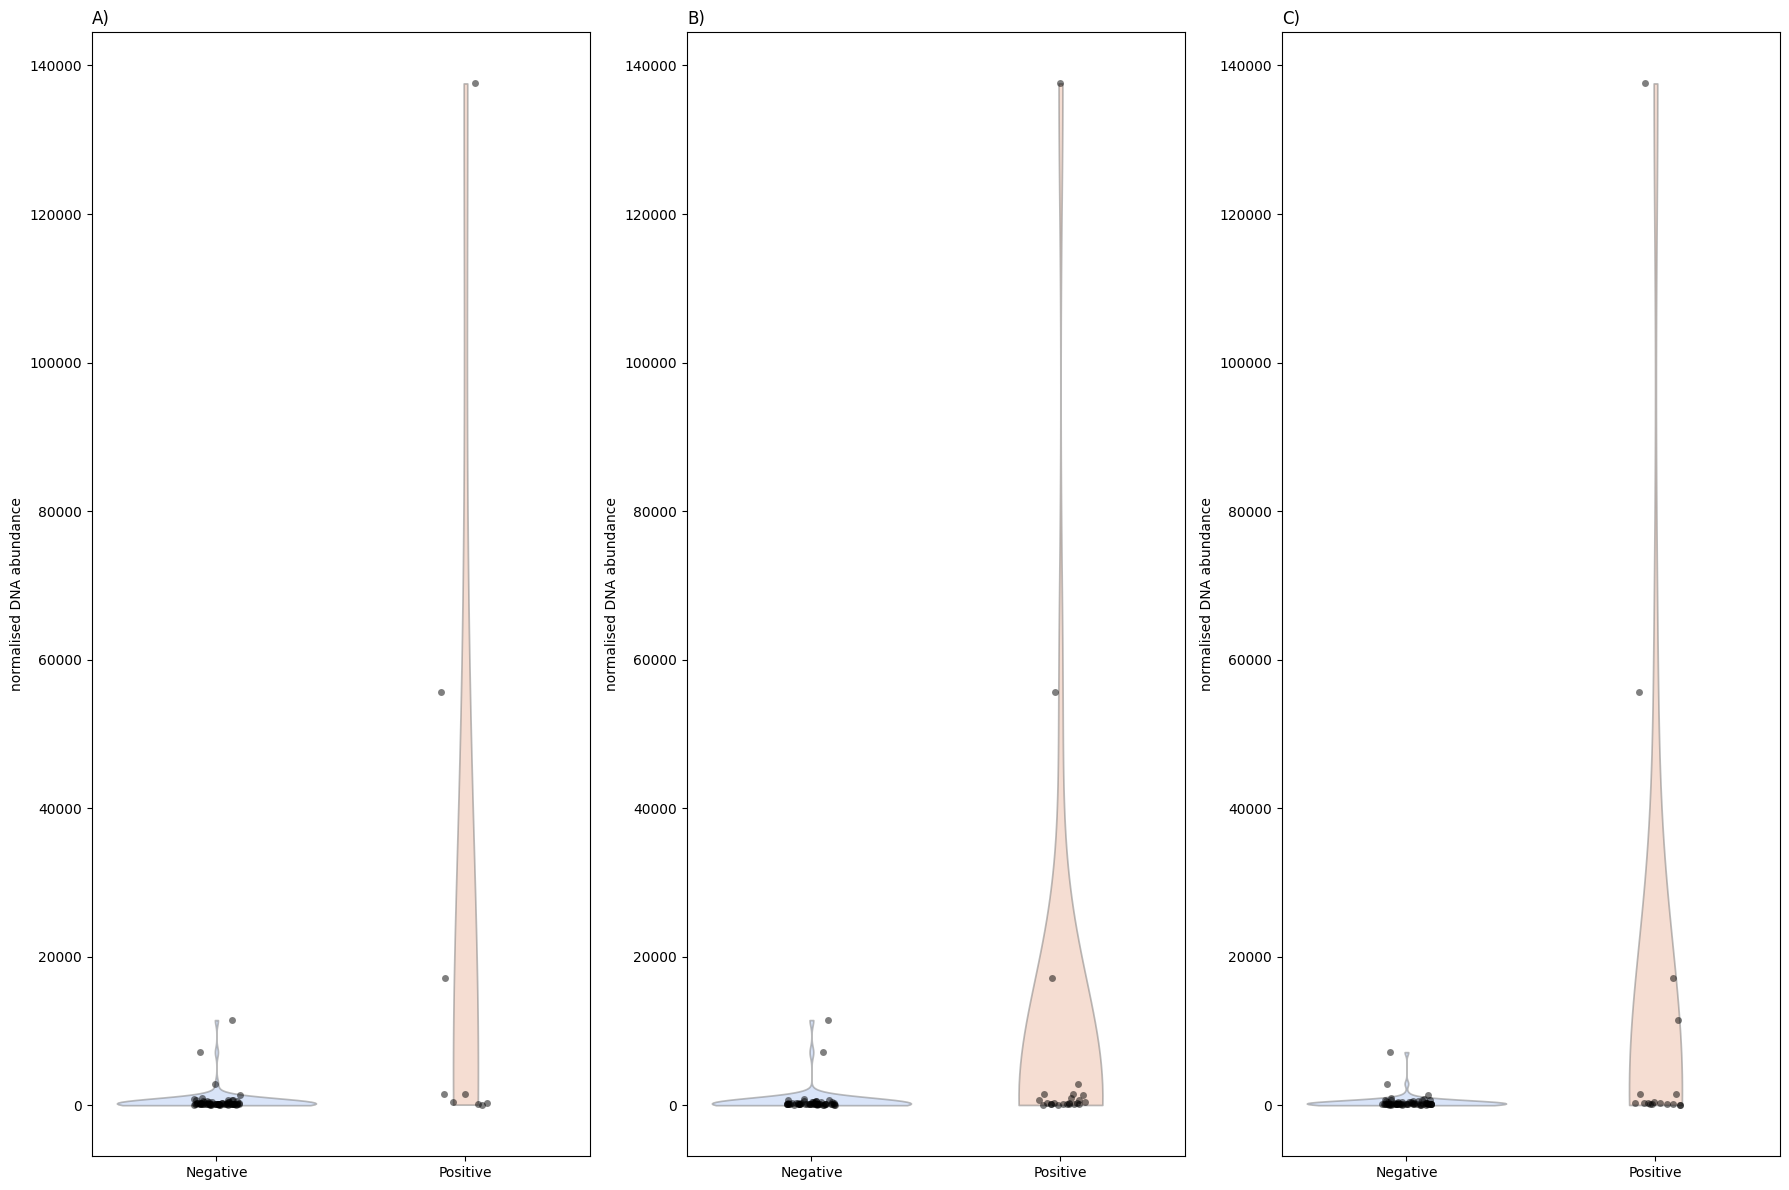

A) Stenophotomonas maltophilia culture status, B) P12M 3 Stenotrophomonas maltophilia culture status, C) N12M Stenotrophomonas maltophilia culture status, (n=81)


In [18]:
fig, ax = plt.subplots(figsize=(18, 12), ncols=3, sharex=False, sharey=False)

y='Xanthomonadaceae'
k = 0
letter = 65
legendstr = ""
for i in [0, 1, 2]:
    culture_taxa = steno.columns[k]
    ctitle = culture_taxa.replace('O_', 'Other ').replace('CS_', '').replace('_', ' ')
    g = sns.violinplot(x=culture_taxa, y=y, data=merged, hue=culture_taxa, palette='coolwarm', alpha=0.5, ax=ax[i], legend=False, inner=None, density_norm='count', common_norm=True, cut=0)
    g = sns.stripplot(x=culture_taxa, y=y, data=merged, color='black', jitter=True, alpha=0.5, ax=ax[i], legend=False)
    g.set_xlabel("")
    g.set_ylabel("normalised DNA abundance")
    g.set_xlim(-0.5, 1.5)
    g.set_xticks(ticks=[0, 1], labels=["Negative", "Positive"])
    legendstr += f"{chr(letter)}) {ctitle} culture status, "
    g.set_title(f"{chr(letter)})", loc='left')
    letter += 1
    k+=1
        
legendstr += f"(n={merged.shape[0]})"
plt.tight_layout()
plt.savefig("final_images/figS7.png", dpi=300)
plt.savefig("final_images/figS7.svg", dpi=300)
plt.show()
print(legendstr)
cf_analysis_lib.create_thumbnail("figS7.png")

## Shap plots to see what is driving positivity

In [13]:
positive_label=1
top_n=None
output_space: str = "probability"

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Map presence label to model class index
classes = np.asarray(model.classes_)
if positive_label not in classes:
    raise ValueError(f"positive_label {positive_label!r} not in model.classes_: {classes}")
pos_idx = int(np.where(classes == positive_label)[0][0])

# Configure explainer safely
if output_space == "probability":
    explainer = shap.TreeExplainer(
        model,
        model_output="raw",
        feature_perturbation="interventional",  # required for probability output
    )
elif output_space == "raw":
    # Fast path (tree_path_dependent); values are in log-odds
    explainer = shap.TreeExplainer(model)
else:
    raise ValueError('output_space must be "probability" or "raw"')

shap_values = explainer.shap_values(X)

# Normalize shapes:
# - Multiclass: list of arrays, one per class -> pick pos_idx
# - Binary:
#   * "probability": newer SHAP typically returns a list [class0, class1]; pick pos_idx
#   * Sometimes returns a single array for P(last_class); if presence != last class, flip sign
#   * "raw": often a single array of log-odds; direction is toward the model's positive output
if isinstance(shap_values, list):
    shap_presence = shap_values[pos_idx]  # shape (n_samples, n_features)
else:
    shap_presence = shap_values  # shape (n_samples, n_features)
    if output_space == "probability":
        # Probability single-array case corresponds to last class
        if pos_idx != (len(classes) - 1):
            shap_presence = -shap_presence
    else:
        # Raw log-odds single-array: sign already indicates move toward the model's raw output
        # (which corresponds to the last class). Flip if presence is not the last class.
        if pos_idx != (len(classes) - 1):
            shap_presence = -shap_presence

mean_shap_presence = shap_presence.mean(axis=0)

ranked_df = pd.DataFrame({
    "feature": X.columns,
    "mean_shap_for_presence": mean_shap_presence
})
ranked_df["abs_mean_shap"] = ranked_df["mean_shap_for_presence"].abs()
ranked_df = ranked_df.sort_values(
    ["mean_shap_for_presence", "abs_mean_shap"],
    ascending=[False, False]
).reset_index(drop=True)

mean_shap_presence = shap_presence.mean(axis=0)
mean_shap_presence_df = pd.DataFrame(mean_shap_presence, index=X.columns, columns=['Mean Shap Presence'])
mean_shap_presence_df['Abs'] = mean_shap_presence_df['Mean Shap Presence'].abs()
mean_shap_presence_df.sort_values(by='Mean Shap Presence', ascending=False)


,Mean Shap Presence,Abs
COPF 121,0.001668,0.001668
COPF 124,0.001610,0.001610
COPF 6,0.001296,0.001296
COPF 50,0.001209,0.001209
COPF 10,0.001058,0.001058
...,...,...
COPF 123,-0.001346,0.001346
COPF 23,-0.001539,0.001539
COPF 95,-0.001607,0.001607
COPF 88,-0.002173,0.002173


In [14]:
mean_shap_presence_df.loc['COPF 120', :]

Mean Shap Presence   -0.001179
Abs                   0.001179
Name: COPF 120, dtype: float64

In [15]:
cluster_assignments[cluster_assignments['COPF']==121]

,COPF,Feature
911,121,Hexose phosphate transport system
912,121,Sutterellaceae
913,121,Gemmataceae
914,121,Pirellulaceae
915,121,Spore germination
916,121,Acidithiobacillaceae
917,121,Solibacteraceae
918,121,Sporomusaceae
919,121,Siderophore Achromobactin
920,121,Nevskiaceae


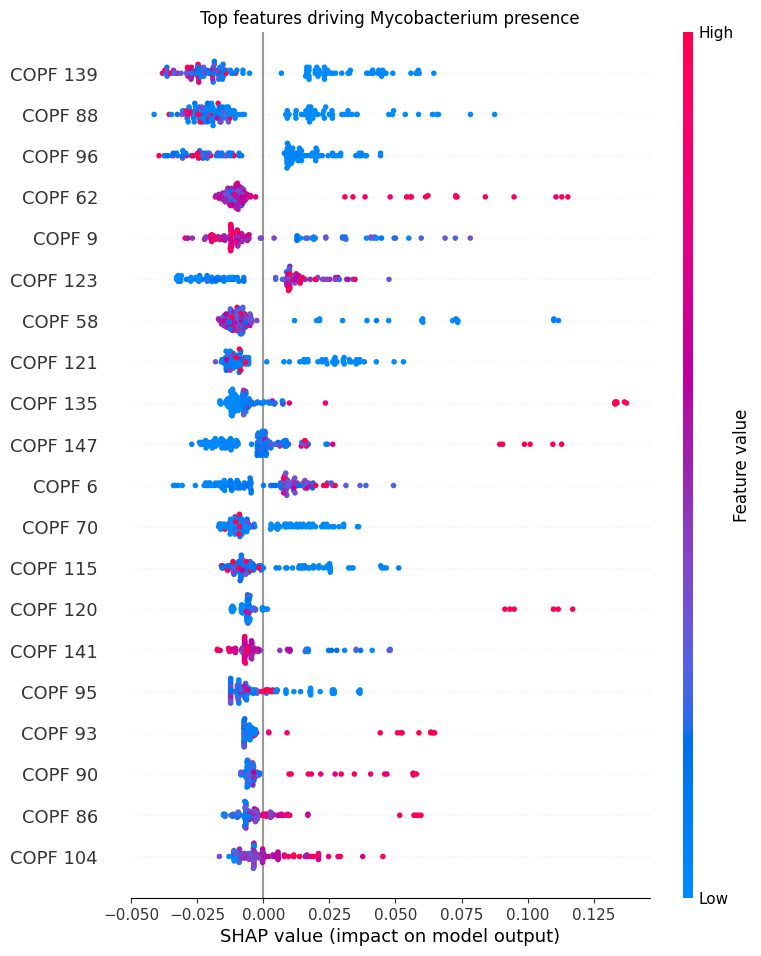

In [16]:
shap.summary_plot(shap_presence, X, show=False)
plt.title("Top features driving Mycobacterium presence")
plt.show()